# Noise models on Rigetti Aspen-M-1 

This notebook shows how to construct a noise model from device calibration data for Rigetti Aspen-M-1. We compare the measurement outcomes of circuits run on a noisy simulator with the same circuits run on quantum processing units (QPUs), to show that simulating circuits with noise models more closely mimics QPUs.

**Before you begin**: We recommend being familiar with [Noise models on Amazon Braket.](https://github.com/aws/amazon-braket-examples/blob/main/examples/getting_started/braket_features/noise_models/Noise_models_on_Amazon_braket.ipynb)
Additionally, users should be familiar with [Running quantum circuits on QPU devices](https://github.com/aws/amazon-braket-examples/blob/main/examples/getting_started/2_Running_quantum_circuits_on_QPU_devices.ipynb). 

### Table of Contents

- Noise model for Rigetti  Aspen-M-1
  - Loading device calibration data
  - Comparing noisy simulator results to QPU results
  - Smaller noise models compared to QPU results

In [1]:
import numpy as np
import pandas as pd
from braket.aws import AwsDevice
from braket.circuits import Circuit, Gate, Noise, Observable
from braket.circuits.noise_model import (GateCriteria, NoiseModel,
                                         ObservableCriteria)
from braket.circuits.noises import (AmplitudeDamping, BitFlip, Depolarizing,
                                    PauliChannel, PhaseDamping, PhaseFlip,
                                    TwoQubitDepolarizing)
from braket.devices import LocalSimulator

Braket console provides calibration data for each QPU. This can be used to construct noise models to approximate the behavior of the QPU when running circuits on a noisy simulator.
In this tutorial, we focus on local noise models with no crosstalk interactions. Real devices can have crosstalk and unexpected effects that can further degrade the results.

The Aspen-M-1 calibration data is available on the Braket devices page. Under qubit specs, the calibration data include the qubit index, with corresponding values for the $T_1$, $T_2$, fidelity from randomized benchmarking (fRB),  fidelity from simultaneous randomized benchmarking (fsRB),  readout fidelity (fRO), and active reset fidelity. 
Under "edge specs", the data includes the RB fidelity for C-Phase, XY, and CZ gates for each connected edge in the device topology.

**One-qubit calibration data (Qubit specs)**
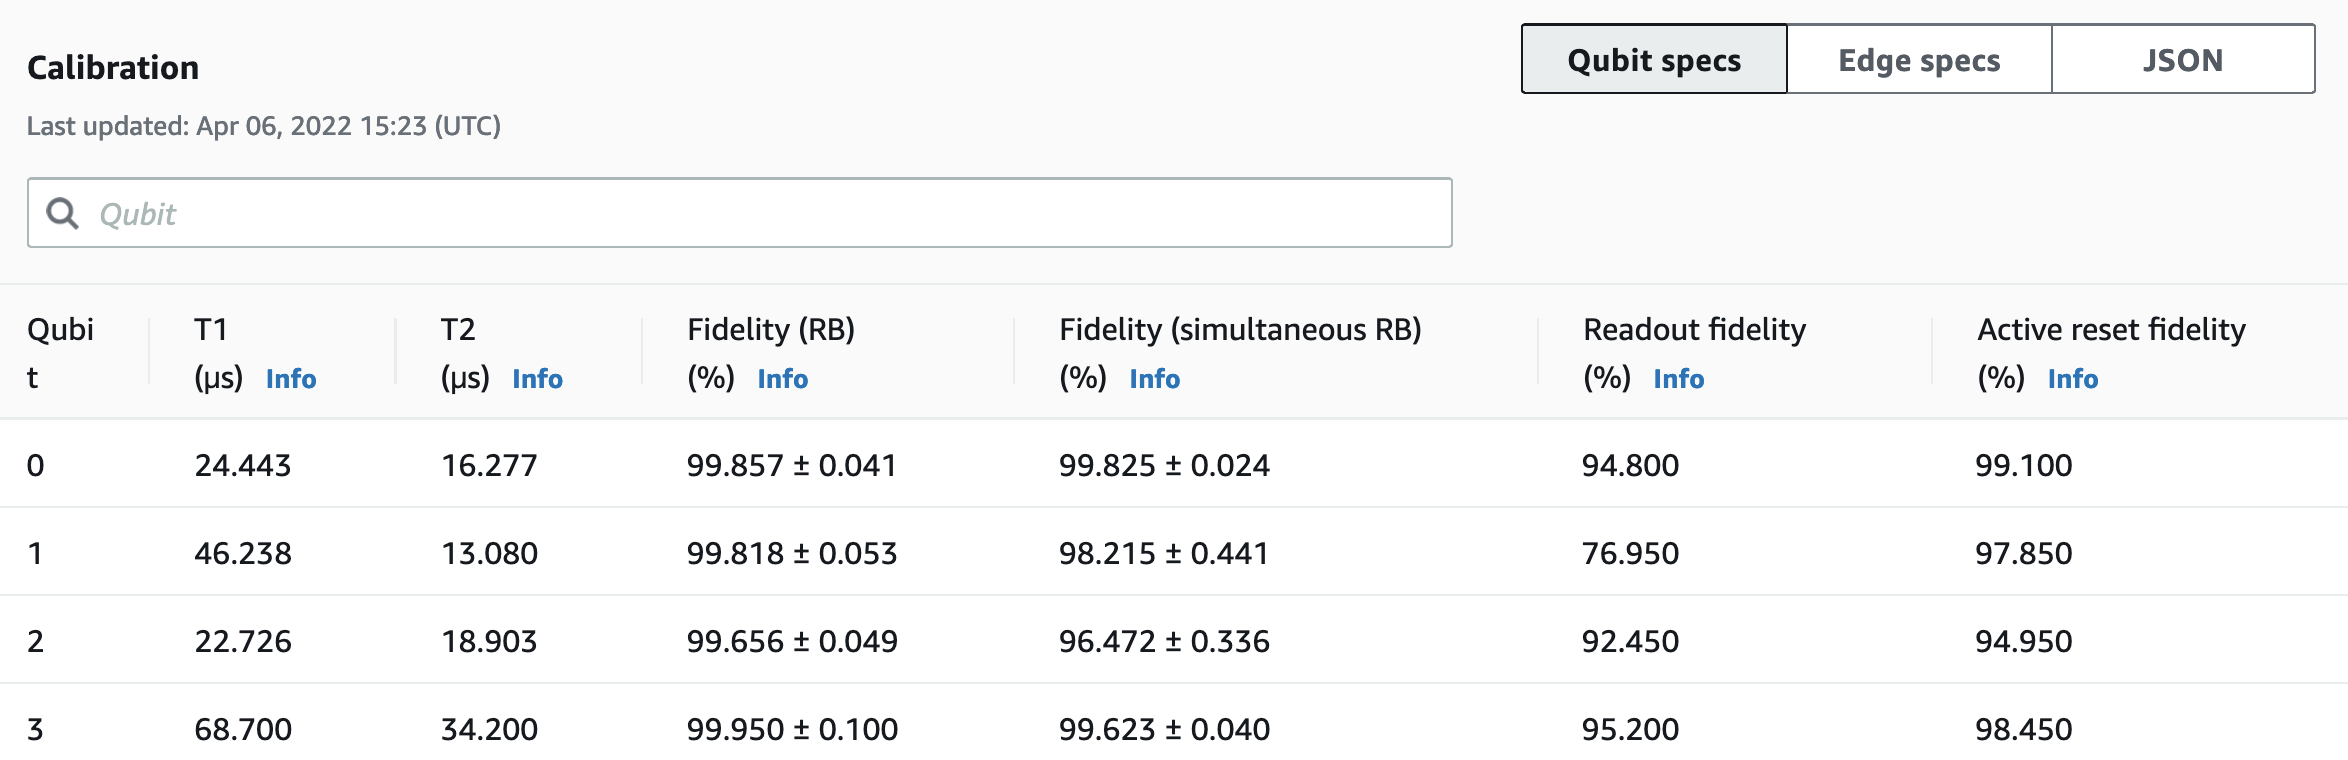

**Two-qubit calibration data (Edge specs)**
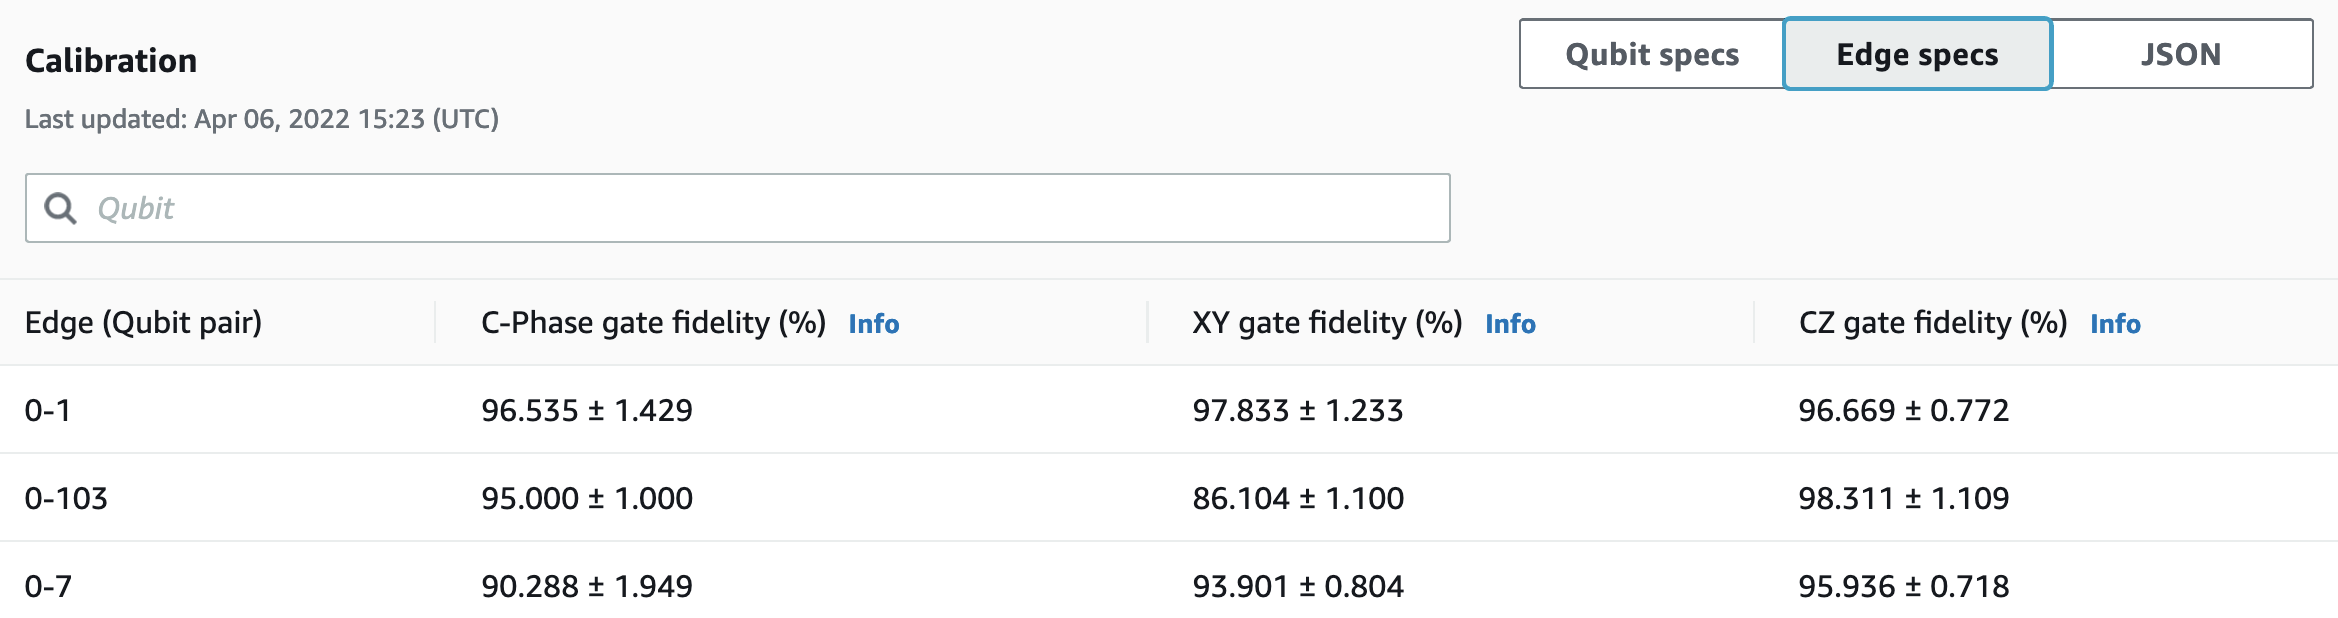

We can programmatically access all the calibration data with the Braket SDK. First we load the AwsDevice using the ARN for Rigetti Apsen-M-1.

In [2]:
aspen_m_1 = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")

The properties dictionary contains keys "provider" and "specs", with "1Q" and "2Q" keys for the one- and two-qubit calibration data. 

In [3]:
aspen_m_1_specs = aspen_m_1.properties.dict()["provider"]["specs"]

one_qubit_data = aspen_m_1_specs["1Q"]
two_qubit_data = aspen_m_1_specs["2Q"]

The keys of the "1Q" dictionary is the qubit number. 
For Aspen-M-1, there are 80 qubits indexed by the first digit representing the octagon (0 to 4, and 10 to 14) 
and the second representing the qubit in that octagon (0 to 7). We can get all qubit indices with `one_qubit_data.keys()` or with `aspen_m_1.topology_graph.nodes`. 

The keys of the "2Q" dictionary are the connected qubit pairs separated by a hyphen. 
For example, if qubit 0 and 1 are connected the key is "0-1".


#### One-qubit noise 

Let's look at the one qubit calibration data for qubit 0.

In [4]:
one_qubit_data["0"]

{'T1': 2.4443429874176914e-05,
 'T2': 1.627681336532139e-05,
 'f1QRB': 0.9985669301541129,
 'f1QRB_std_err': 0.0004092835114091019,
 'f1Q_simultaneous_RB': 0.9977676229871197,
 'f1Q_simultaneous_RB_std_err': 0.00021522363993495725,
 'fActiveReset': 0.9905000000000002,
 'fRO': 0.9795}

For each qubit, there are various metrics of the quality:

- **T1**: Thermal relaxation time is related to the time it takes for the excited state, |1⟩, to decay into the ground state, |0⟩. The probability of remaining in the excited state is $p(|1⟩)\sim e^{-t/T_1}$

- **T2**: The dephasing time, is the decay constant for the scale for a |+⟩ state to decohere into the completely mixed state. $p(|+⟩)\sim e^{-t/T_2}$ 

- **Fidelity (RB)**: Single-qubit randomized benchmarking fidelities. RB fidelity quantifies the average gate fidelity where the average is over all Clifford gates. RB describes an *effective* noise model with gate-independent depolarizing noise on each Clifford gate.

- **Fidelity (sRB)**: Single-qubit simultaneous randomized benchmarking fidelities. These are extracted by running single-qubit RB on all qubits simultaneously. Note that we expect the sRB fidelity to be lower than standard RB fidelity due to non-local crosstalk type noise on the device. 

- **Active reset fidelity**: Single-qubit active reset fidelities represents the accuracy to which qubits are reinitalized into the ground state |0⟩.

- **Readout fidelity**: Single-qubit readout fidelities describes the probability of a bit flip error before readout in the computational basis. The readout fidelity is related to the probability of correctly measuring the ground state and excited states respectively, e.g. $f_{RO} =\frac{p(0|0)+p(1|1)}{2}$

Now that we know how to extract and use the calibration data, we can build a simple noise model. For every qubit we will add:
- amplitude dampening noise with probability $p= 1-e^{-t/T_1}$ for every gate
- phase dampening noise with probability $p= 0.5(1-e^{-t/T_2})$ for every gate
- depolarizing noise with probability $p=1-f_{sRB}$ (from simultaneous RB fidelity) for  every gate
- readout bit flip noise with probability $p=1-f_{RO}$ to measurements 

Technically, the sRB fidelity already includes effects from $T_1$/$T_2$, however to be explicit we add these as separate terms. In a sense, this model might overestimate the noise on the QPU.  

For the dampening noises, we first need the gate times to model $T_1$ and $T_2$ errors.
From the Braket Aspen-M-1 device page: "These gates offer fast (40ns and 180ns) 1Q and 2Q gate times."

In [5]:
# median 1q and 2q gate times
gate_time_1_qubit = 40e-9
gate_time_2_qubit = 180e-09

To create the noise model, we iterate over all qubits keys in `one_qubit_data`

In [6]:
noise_model = NoiseModel()

# Single-qubit noise
for q, data in one_qubit_data.items():  # iterate over qubits

    # T1 dampening
    t1 = data["T1"]
    damping_prob = 1 - np.exp(-(gate_time_1_qubit / t1))
    noise_model.add_noise(AmplitudeDamping(damping_prob), GateCriteria(qubits=int(q)))

    # T2 phase flip
    t2 = data["T2"]
    dephasing_prob = 0.5 * (1 - np.exp(-(gate_time_1_qubit / t2)))
    noise_model.add_noise(PhaseDamping(dephasing_prob), GateCriteria(qubits=int(q)))

    # 1q RB depolarizing rate from simultaneous RB
    depolar_rate = 1 - data["f1Q_simultaneous_RB"]
    noise_model.add_noise(Depolarizing(depolar_rate), GateCriteria(qubits=int(q)))

    # 1q RB readout
    readout_value = 1 - data["fRO"]
    noise_model.add_noise(BitFlip(readout_value), ObservableCriteria(qubits=int(q)))

In [7]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print(f"Number of terms in noise model is: {len(noise_model.instructions)}")
print(f"Number of parameters in noise model is: {num_params}")

Number of terms in noise model is: 320
Number of parameters in noise model is: 320


#### Two-qubit noise 
Next we consider adding two-qubit noise to the model. 

Let's first look at the data provided in the Aspen-M-1 device calibration data. On the first connect, "0-1", the properties are:

In [8]:
two_qubit_data["0-1"]

{'fCPHASE': 0.8991973184700036,
 'fCPHASE_std_err': 0.019391126441846068,
 'fCZ': 0.9406104552003762,
 'fCZ_std_err': 0.011069113247524152,
 'fXY': 0.8365560014004874,
 'fXY_std_err': 0.014585224789608713}

Here, we see the fidelity per gate (CPhase, CZ, or XY) and the associated standard error. 

Next we loop over the entries in the `two_qubit_data` dictionary and add two-qubit depolarizing noise to the model. Notice that Aspen-M-1 has symmetric connections ("0-1" and "1-0") so we need to add noise in both directions. 

In [9]:
# Two-qubit noise
for pair, data in two_qubit_data.items():  # iterate over qubit connections

    # parse strings "0-1" to integers [0, 1]
    q0, q1 = (int(s) for s in pair.split("-"))

    if "fCPHASE" in data:
        phase_rate = 1 - data["fCPHASE"]
        noise_model.add_noise(
            TwoQubitDepolarizing(phase_rate),
            GateCriteria(
                Gate.CPhaseShift, [(q0, q1), (q1, q0)]
            ),  # symmetric connections
        )

    if "fXY" in data:
        xy_rate = 1 - data["fXY"]
        noise_model.add_noise(
            TwoQubitDepolarizing(xy_rate), GateCriteria(Gate.XY, [(q0, q1), (q1, q0)])
        )

    if "fCZ" in data:
        cz_rate = 1 - data["fCZ"]
        noise_model.add_noise(
            TwoQubitDepolarizing(cz_rate), GateCriteria(Gate.CZ, [(q0, q1), (q1, q0)])
        )

In [10]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print(f"Number of terms in noise model is: {len(noise_model.instructions)}")
print(f"Number of parameters in noise model is: {num_params}")

Number of terms in noise model is: 612
Number of parameters in noise model is: 612


### Compare circuits run on device vs simulator with a noise model

Let's just look at the first 5 qubits. Note that to ensure the noise model applied T1 and T2 noise during the time between gate, we manually add identity gates to each moment.

In [11]:
from braket.circuits import Circuit, Noise

np.random.seed(42)

circ = Circuit().rx(0, 0.5).rz(1, 0.5).rz(2, 0.5).rx(0, np.pi).rx(1, np.pi).rx(2, np.pi).cz(0, 1)
print(circ)

T  : |   0    |   1    |2|
                          
q0 : -Rx(0.50)-Rx(3.14)-C-
                        | 
q1 : -Rz(0.50)-Rx(3.14)-Z-
                          
q2 : -Rz(0.50)-Rx(3.14)---

T  : |   0    |   1    |2|


In [12]:
noisy_circ = noise_model.apply(circ)

print(noisy_circ)

T  : |                     0                      |                     1                      |      2      |
                                                                                                              
q0 : -Rx(0.50)-AD(0.0016)--PD(0.0012)-DEPO(0.0022)-Rx(3.14)-AD(0.0016)--PD(0.0012)-DEPO(0.0022)-C-DEPO(0.059)-
                                                                                                | |           
q1 : -Rz(0.50)-AD(0.00086)-PD(0.0015)-DEPO(0.025)--Rx(3.14)-AD(0.00086)-PD(0.0015)-DEPO(0.025)--Z-DEPO(0.059)-
                                                                                                              
q2 : -Rz(0.50)-AD(0.0018)--PD(0.0011)-DEPO(0.0041)-Rx(3.14)-AD(0.0018)--PD(0.0011)-DEPO(0.0041)---------------

T  : |                     0                      |                     1                      |      2      |


In [13]:
simulator = LocalSimulator()  # noise free simulator
task = simulator.run(circ, shots=100_000)
free_probs = task.result().measurement_probabilities

In [14]:
noisy_simulator = LocalSimulator("braket_dm")
noisy_task = noisy_simulator.run(noisy_circ, shots=100_000)
noisy_probs = noisy_task.result().measurement_probabilities

<div class="alert alert-block alert-info">
<b>Note:</b> The below section runs tasks on the Rigetti Aspen-M-1 device. When you run this notebook, make sure the device is currently available. You can find QPU availability windows on the <a href=\"https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/devices\">Devices page</a> in the Amazon Braket Console.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Running the circuit below will result in charges on your AWS account.
</div>

In [15]:
aspen_m_1_task = aspen_m_1.run(circ, shots=100_000, disable_qubit_rewiring=True)
aspen_m_1_result = aspen_m_1_task.result()
aspen_m_1_probs = aspen_m_1_result.measurement_probabilities

In [16]:
free_sim = pd.DataFrame.from_dict(free_probs, orient="index").rename(
    columns={0: "free_sim"}
)
noisy_sim = pd.DataFrame.from_dict(noisy_probs, orient="index").rename(
    columns={0: "noisy_sim"}
)
aspenm1 = pd.DataFrame.from_dict(aspen_m_1_probs, orient="index").rename(
    columns={0: "aspen-m-1"}
)
df = aspenm1.join(noisy_sim).join(free_sim)
df

,aspen-m-1,noisy_sim,free_sim
000,0.00136,0.00016,NaN
111,0.68340,0.85721,0.93927
110,0.07619,0.00635,NaN
011,0.12967,0.07411,0.06073
101,0.07366,0.04401,NaN
100,0.00777,0.00023,NaN
010,0.01303,0.00045,NaN
001,0.01492,0.01748,NaN


We can compute the fidelity between the free simulation and Rigetti, as well as the noisy simulation and Rigetti. 

In [17]:
def fidelity(p, q):
    return np.sum(np.sqrt(p * q))


f_free_aspen = fidelity(df["free_sim"], df["aspen-m-1"])
f_noisy_aspen = fidelity(df["noisy_sim"], df["aspen-m-1"])

print(f"\nTotal fidelity between Aspen-M-1 and noise-free simulator is {f_free_aspen}")
print(f"\nTotal fidelity between Aspen-M-1 and noisy simulator is {f_noisy_aspen}")


Total fidelity between Aspen-M-1 and noise-free simulator is 0.8899252242353248

Total fidelity between Aspen-M-1 and noisy simulator is 0.9627231692802513


To better visualize, we can also plot the output probability distributions from each circuit:

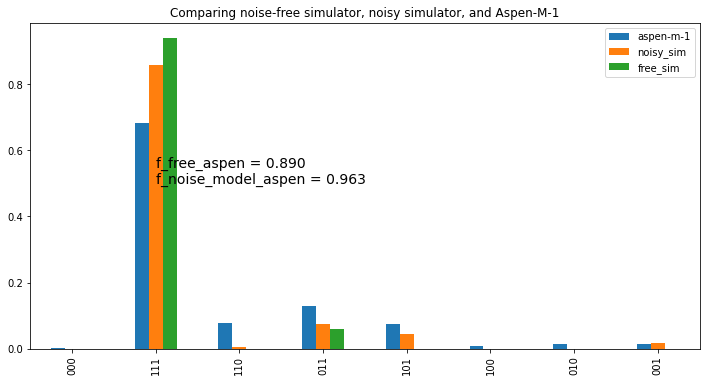

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

df.plot.bar(
    title="Comparing noise-free simulator, noisy simulator, and Aspen-M-1",
    figsize=(12, 6),
)

text = f"f_free_aspen = {f_free_aspen:.3f} \nf_noise_model_aspen = {f_noisy_aspen:.3f}"
plt.text(1, 0.5, text, fontsize=14)
plt.show()

We confirm that the simulator with a noise model is closer to the distribution produced by Aspen-M-1. 

### Smaller, reduced noise models

The full Rigetti Aspen-M-1 noise model contains due to non-uniform qubit noise. We can obtain simpler, smaller noise models by coarse graining the model above. 

Here, we consider taking the average over all qubits for the $T_1$, $T_2$, depolarizing, and readout depolarizing rates. This is a substantially smaller noise model, but may be less accurate. 

We use the `from_filter` function to extract all instructions with amplitude dampening noise in the model. We then compute the mean of the error probabilities. 

In [18]:
avg_t1 = np.mean(
    [
        n.noise.parameters
        for n in noise_model.from_filter(noise=AmplitudeDamping).instructions
    ]
)
avg_t2 = np.mean(
    [
        n.noise.parameters
        for n in noise_model.from_filter(noise=PhaseDamping).instructions
    ]
)
avg_depo = np.mean(
    [
        n.noise.parameters
        for n in noise_model.from_filter(noise=Depolarizing).instructions
    ]
)
avg_readout = np.mean(
    [n.noise.parameters for n in noise_model.from_filter(noise=BitFlip).instructions]
)

Now we construct a new noise model with the mean values above:

In [19]:
simple_noise_model = NoiseModel()
simple_noise_model.add_noise(AmplitudeDamping(avg_t1), GateCriteria())
simple_noise_model.add_noise(PhaseDamping(avg_t2), GateCriteria())
simple_noise_model.add_noise(Depolarizing(avg_depo), GateCriteria())
simple_noise_model.add_noise(BitFlip(avg_readout), ObservableCriteria())

print(simple_noise_model)

Gate Noise:
  AmplitudeDamping(0.0019483910859341453), GateCriteria(None, None)
  PhaseDamping(0.0018677309884621795), GateCriteria(None, None)
  Depolarizing(0.007153677053977023), GateCriteria(None, None)
Readout Noise:
  BitFlip(0.053481250000000015), ObservableCriteria(None, None)


We can see the resultant circuits contain qubit-independent noise:

In [20]:
simple_noisy_circ = simple_noise_model.apply(circ)
print(simple_noisy_circ)

T  : |                     0                     |                 1                  |                     2                     |
                                                                                                                                   
q0 : -Rx(0.75)-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-C-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-I--------AD(0.0019)-PD(0.0019)-DEPO(0.0072)-
                                                  |                                                                                
q1 : -I--------AD(0.0019)-PD(0.0019)-DEPO(0.0072)-Z-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-Rx(0.50)-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-
                                                                                                                                   
q2 : -Rz(0.50)-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-I-AD(0.0019)-PD(0.0019)-DEPO(0.0072)-I--------AD(0.0019)-PD(0.0019)-DEPO(0.0072)-

T  : |                     0                     |                 1       

We run the circuit on a noisy simulator below

In [21]:
simple_noisy_task = noisy_simulator.run(simple_noisy_circ, shots=100_000)
simple_noisy_probs = simple_noisy_task.result().measurement_probabilities

and add it to the previous dataframe

In [22]:
simple_noisy_sim = pd.DataFrame.from_dict(simple_noisy_probs, orient="index").rename(
    columns={0: "simple_noisy_sim"}
)
df = df.join(simple_noisy_sim)
df

,aspen-m-1,noisy_sim,free_sim,simple_noisy_sim
000,0.53302,0.74544,0.81380,0.78149
100,0.11748,0.13151,0.12486,0.13176
010,0.24681,0.08706,0.05338,0.06130
110,0.05687,0.02742,0.00796,0.01061
011,0.01819,0.00055,NaN,0.00096
111,0.00477,0.00021,NaN,0.00015
001,0.01892,0.00650,NaN,0.01179
101,0.00394,0.00131,NaN,0.00194


We compute the fidelity between the simple noise model and the QPU:

In [23]:
f_simple = fidelity(df["simple_noisy_sim"], df["aspen-m-1"])

print(f"\nTotal fidelity between Aspen-M-1 and full noise model is: {f_noisy_aspen}")
print(f"\nTotal fidelity between Aspen-M-1 and simple noise model is: {f_simple}")
print(f"\nTotal fidelity between Aspen-M-1 and noise-free is: {f_free_aspen}")


Total fidelity between Aspen-M-1 and full noise model is: 0.9582415634979304

Total fidelity between Aspen-M-1 and simple noise model is: 0.9401126418474742

Total fidelity between Aspen-M-1 and noise-free is: 0.915784824249657


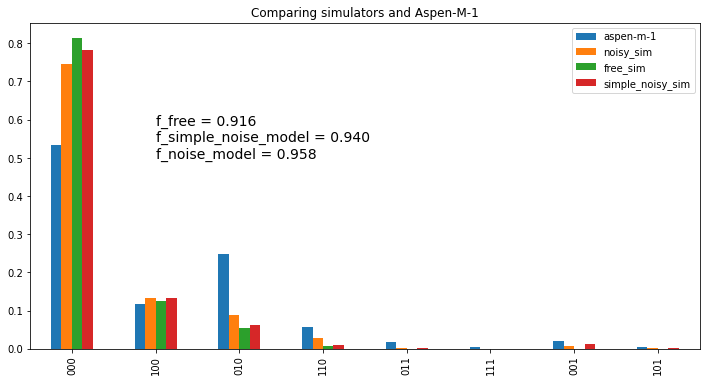

In [24]:
df.plot.bar(title="Comparing simulators and Aspen-M-1", figsize=(12, 6))
text = f"f_free = {f_free_aspen:.3f} \nf_simple_noise_model = {f_simple:.3f} \nf_noise_model = {f_noisy_aspen:.3f}"
plt.text(1, 0.5, text, fontsize=14)
plt.show()

We see that compared to the full noise model, the simple model is less accurate, however, it is still a significant improvement over the noise-free case and has far fewer parameters in the model. 

## Summary

In this notebook, we showed how to construct a noise model for Rigetti Aspen-M-1 based only on the available calibration data. 
We used a coarse assumption of gate-independent single-qubit depolarizing noise and gate-dependant two-qubit noise. Our qubit-dependent model could be improved in many ways. We could add gate-dependence noise, or change the depolarizing channel to Pauli channels. 